# Temporal HMP

In the sequel, for $a\in \R$, we set $a_+:=\max(0,a)$ and let $\rho>0$. Hereafter, admissible controls are measurable functions over $[0,2]$ with values in $[-1,1]$.

We consider the temporally hybrid optimal control problem:

$$
\mathrm{min}_{\tau,u(\cdot)} \; -(x(2)-2)^3-\rho \int_0^2 (1-x(t))_+^2 \, \mathrm{d} t \quad \mathrm{s.t.} \; 
\left\{
\begin{array}{cl}
\dot{x}(t)&=
\left|
\begin{array}{lll}
u(t)+2 & \mathrm{if} & t\in [0,\tau),\\
u(t) & \mathrm{if} & t\in (\tau,2],\\
\end{array}
\right.
\\
x(0)&=0 \quad \mathrm{and} \; \; x(\tau)=1.
\end{array}\right.
$$

where $\tau\in (0,2)$ is an additional optimization parameter.

In [12]:
using Pkg
Pkg.activate(".")
Pkg.status()

using Plots.PlotMeasures
using OptimalControl
pixels = PlotMeasures.px;

  Activating project at `~/Boulot/recherche/control-loss/simulations/HMP`


Status `~/Boulot/recherche/control-loss/simulations/HMP/Project.toml`
  [5f98b655] OptimalControl v0.7.5


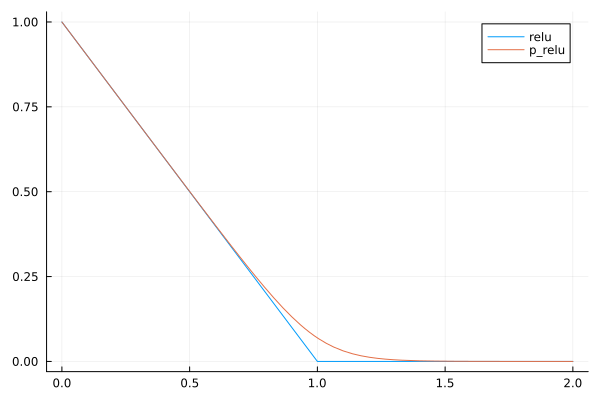

In [2]:
# define the relu function
relu(x) = max(0, x)

# define the parametric relu function
μ = 10
p_relu(x) = log(abs(1 + exp(μ*x)))/μ

# the function inside the Lagrange part of the cost of the optimal control problem
f(x) = 1-x

# the regularized function
m(x) = (p_relu∘f)(x)

# plot the relu function and the parametric relu function
plot(relu∘f, 0, 2, label="relu")
plot!(m, 0, 2, label="p_relu")

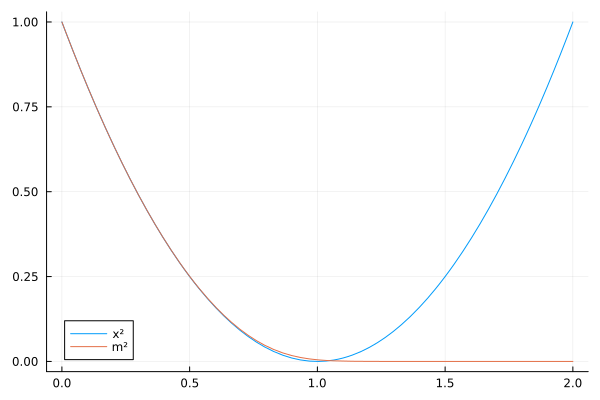

In [3]:
# plot the square of f and m
plot(x -> f(x)^2, 0, 2, label="x²")
plot!(x -> m(x)^2, 0, 2, label="m²")

In [4]:
# constant parameters of the optimal control problem
T = 2

# definition of the optimal control problem
function myocp(ρ)

    @def ocp begin
        τ ∈ R, variable
        s ∈ [ 0, 1 ], time
        x ∈ R², state
        u ∈ R², control
        x₁(0) == 0
        x₂(0) == 1
        x₁(1) == 1
        ẋ(s) == [τ*(u₁(s)+2), (T-τ)*u₂(s)]
        -1 ≤ u₁(s) ≤ 1
        -1 ≤ u₂(s) ≤ 1
        0 ≤ τ ≤ T
        -(x₂(1)-2)^3 - ∫( ρ * ( τ*m(x₁(s))^2 + (T-τ)*m(x₂(s))^2 ) ) → min
    end

    return ocp

end

# plot the optimal control problem
function myplot(sol::OptimalControl.OptimalControlSolution, ρ; kwargs...)

    tt = sol.times
    xx = sol.state
    uu = sol.control
    pp = sol.costate
    τ  = sol.variable

    t = vcat(τ*tt, τ.+(T-τ)*tt)
    s(t) = (0≤t≤τ)*(t/τ) + (τ<t≤T)*((t-τ)/(T-τ))
    x(t) = (0≤t≤τ)*xx(s(t))[1]+(τ<t≤T)*xx(s(t))[2]
    u(t) = (0≤t≤τ)*uu(s(t))[1]+(τ<t≤T)*uu(s(t))[2]
    p = t -> (0≤t≤τ)*pp(s(t))[1]+(τ<t≤T)*pp(s(t))[2]

    px = plot(t, x, label="x", xlims=(-0.1, T+0.1), ylims=(-1.0, 2.0), z_order=:front, linewidth=2)

    # put the value of ρ in the ylabel
    plot!(px, ylabel="ρ = $ρ")

    pu = plot(t, u, label="u", ylims=(-1.1, 1.1), z_order=:front, linewidth=2, color=:red)
    plot!(pu, [0, T], [ 1,  1], label="", color=:black, linestyle=:dash, z_order=:back)
    plot!(pu, [0, T], [-1, -1], label="", color=:black, linestyle=:dash, z_order=:back)

    pp = plot(t, p, label="p", z_order=:front, linewidth=2, color=:green)

    plt = plot(px, pu, pp, layout=(1, 3); kwargs...)

    return plt

end;

In [10]:
#
ρs = [0.1, 5, 10, 30, 100]

# 
sols = [] 

# init 
init = (state=t->[t, 1+t], control=[-1, 1], variable=0.5)

for ρ in ρs

    # define the optimal control problem
    ocp = myocp(ρ)

    # resolution
    sol = solve(ocp, init=init) # the init is not important

    # new init 
    # init = sol # this is not working

    # add the solution to the list of solutions
    push!(sols, sol)

end

Method = (:direct, :adnlp, :ipopt)


This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:     1704
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      606

Total number of variables............................:      506
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 1.00e-01 3.17e-04   0.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:     1704
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      606

Total number of variables............................:      506
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 1.00e-01 1.06e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:     1704
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      606

Total number of variables............................:      506
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 1.00e-01 1.07e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

:direct, :adnlp, :ipopt)


This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:     1704
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      606

Total number of variables............................:      506
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 1.51e-01 1.62e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:     1704
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      606

Total number of variables............................:      506
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 5.02e-01 2.26e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

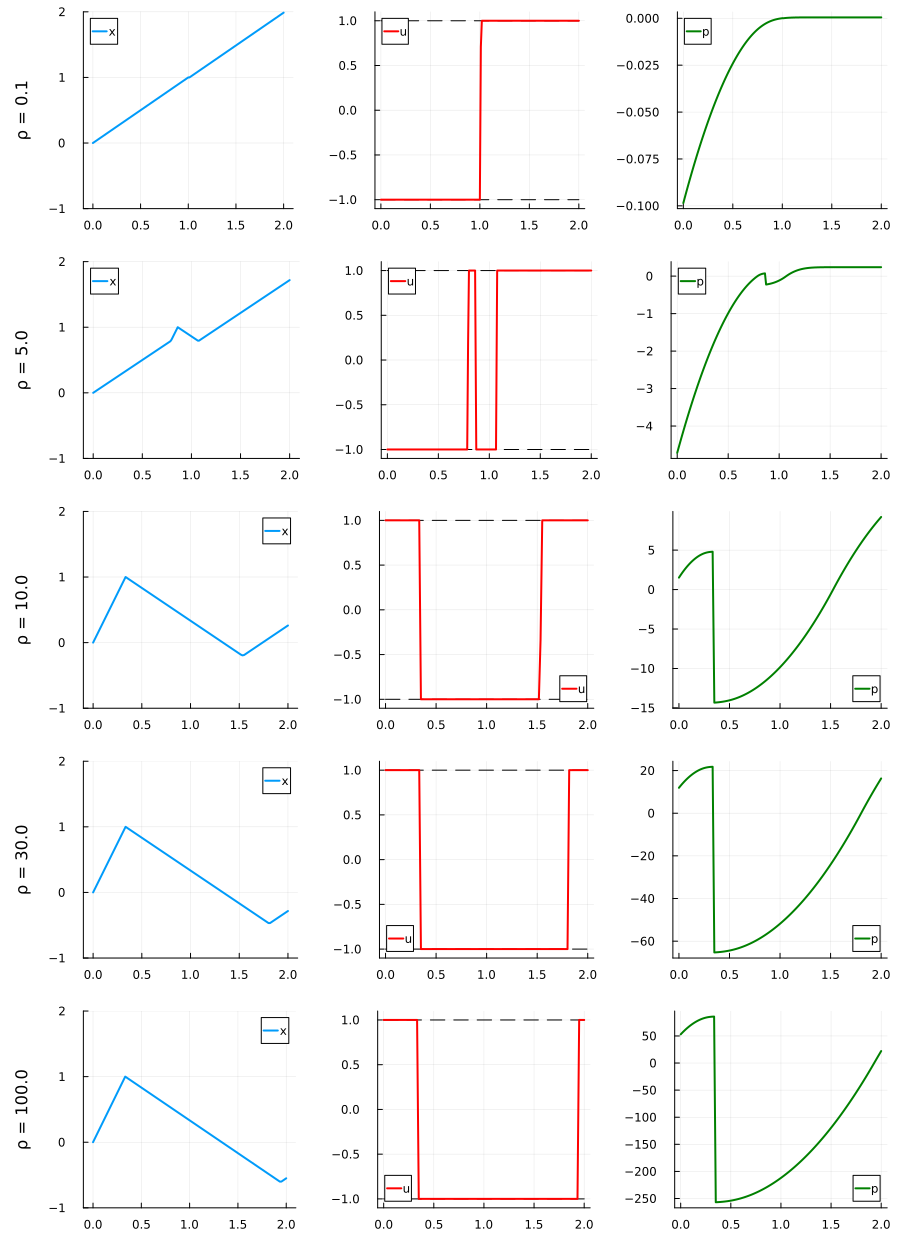

In [11]:
#
plts = []

for (ρ, sol) in zip(ρs, sols)

    # the plot of the solution
    plt = myplot(sol, ρ)

    # add the plot to the list of plots
    push!(plts, plt)

end

# plot the list of plots
plot(plts..., layout=(length(plts), 1), size=(900, 250*length(ρs)), left_margin=30pixels)